<a href="https://colab.research.google.com/github/GalBuzi/colab/blob/main/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
from google.colab import drive
from google.colab import files

import os
import nltk
import pandas as pd
import numpy as np
import string
import pprint
import matplotlib.pyplot as plt
import re
import operator
from collections import Counter, OrderedDict
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer



drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


**Read Data and split it :**

In [48]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger')

# csv_file = pd.read_csv("gdrive/My Drive/small_imdb_data.csv")
csv_file = pd.read_csv("gdrive/My Drive/IMDB Dataset.csv")

nltk_stop_words = stopwords.words('english')

# split to train and test
# y = csv_file.sentiment
# x = csv_file.drop('sentiment', axis=1)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
# y_train

print(csv_file.shape[0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
50000


**Data Prepartion:**

In [49]:
def clean_and_normalize_review_text(review):
    # remove tags
    clean_tags = re.compile('<.*?>')
    re_negation = re.compile("n't ")
    tokens1 = re.sub(clean_tags, '', review)
    tokens1 = re_negation.sub(" not ", tokens1)

    # create bi-grams
    bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=1)
    analyze = bigram_vectorizer.build_analyzer()
    tokens2 = analyze(tokens1)

    # split into words
    # tokens2 = word_tokenize(tokens1)

    # convert to lower case
    tokens3 = [w.lower() for w in tokens2]

    # remove punctuation
    table = str.maketrans('', '', string.punctuation)
    tokens4 = [w.translate(table) for w in tokens3]

    # remove remaining tokens that are not alphabetic
    tokens5 = [word for word in tokens4 if word != ' ' and all(x.isalpha() or x.isspace() for x in word)]

    # filter out stop words
    stop_words = set(stopwords.words('english'))
    # tokens6 = [w for w in tokens5 if w not in stop_words]
    tokens6 = []
    for w in tokens5:
        check = w.split(' ')
        if len(check) == 1:
            if w not in stop_words:
                tokens6.append(w)
        elif len(check) == 2: 
            if check[0] in stop_words and check[1] in stop_words:
                continue
            else:
                tokens6.append(w)


    # lemmatization
    lemma = WordNetLemmatizer()
    tokens7 = [lemma.lemmatize(word) for word in tokens6]

    return tokens7

In [50]:
# cleaning data text
for index, row in csv_file.iterrows():
  csv_file.loc[index,'review'] = clean_and_normalize_review_text(row['review'])
  csv_file.loc[index,'review_text'] = ' '.join( csv_file.loc[index,'review'] )

# train_data.drop('review', axis='columns', inplace=True)


In [51]:
# Explore train set reviews:

train_sentiment = csv_file['sentiment'].to_frame(name='sentiment')

#number of positive/negative reviews in train set:
pos_count = train_sentiment[train_sentiment['sentiment'] == 'positive'].count()
neg_count = train_sentiment[train_sentiment['sentiment'] == 'negative'].count()
print("number of positive reviews in train set: " + str(pos_count))
print("number of negative reviews in train set: " + str(neg_count))



number of positive reviews in train set: sentiment    25000
dtype: int64
number of negative reviews in train set: sentiment    25000
dtype: int64


In [52]:
# creating positive and negative dataframes from the train set
positive_reviews_train = csv_file[csv_file['sentiment'] == 'positive']
negative_reviews_train = csv_file[csv_file['sentiment'] == 'negative']
positive_reviews_train

,review,sentiment,review_text
0,"[one, reviewer, mentioned, watching, oz, episo...",positive,one reviewer mentioned watching oz episode hoo...
1,"[wonderful, little, production, filming, techn...",positive,wonderful little production filming technique ...
2,"[thought, wonderful, way, spend, time, hot, su...",positive,thought wonderful way spend time hot summer we...
4,"[petter, mattei, love, time, money, visually, ...",positive,petter mattei love time money visually stunnin...
5,"[probably, time, favorite, movie, story, selfl...",positive,probably time favorite movie story selflessnes...
...,...,...,...
49983,"[loved, fan, original, series, always, wondere...",positive,loved fan original series always wondered back...
49985,"[imaginary, hero, clearly, best, film, year, c...",positive,imaginary hero clearly best film year complete...
49989,"[got, one, week, ago, love, modern, light, fil...",positive,got one week ago love modern light filled true...
49992,"[john, garfield, play, marine, blinded, grenad...",positive,john garfield play marine blinded grenade figh...


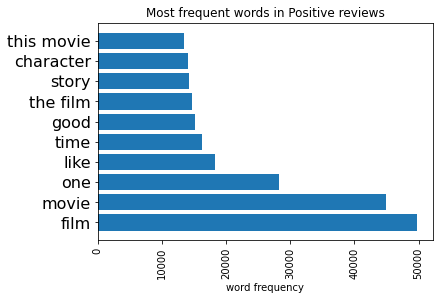

In [53]:
# show top 10 terms in positive reviews
corpus_pos = list(positive_reviews_train['review'])
dict_words = {}
for doc in corpus_pos:
  for word in doc:
    if word in dict_words.keys():
      dict_words[word] = dict_words[word] + 1
    else:
      dict_words[word] = 1

dict_words_top10 = sorted(dict_words.items(), key=operator.itemgetter(1),reverse=True)
dict_words_top10 = dict_words_top10[:10]
plt.barh(*zip(*dict_words_top10))
plt.title('Most frequent words in Positive reviews')
plt.xlabel('word frequency')
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=16)
plt.show()

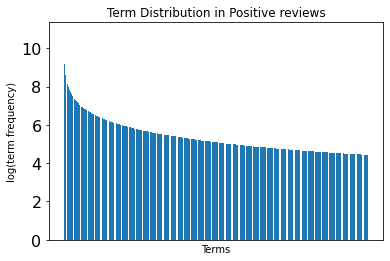

In [54]:
# Term Distribution - Positive - highest 10K terms

import math
dict_words = {k: math.log(v) for k, v in dict_words.items()}
dict_words = sorted(dict_words.items(), key=operator.itemgetter(1),reverse=True)
dict_words = dict_words[:10000]

plt.bar(*zip(*dict_words))
plt.title('Term Distribution in Positive reviews')
plt.xlabel('Terms')
plt.ylabel('log(term frequency)')
plt.xticks([], [])
plt.yticks(fontsize=16)
plt.show()

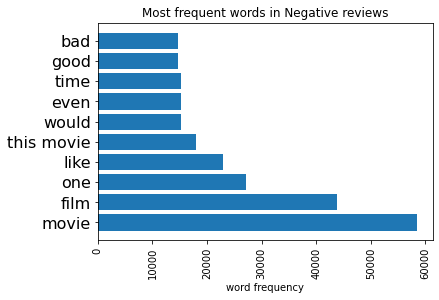

In [55]:
# show top 10 terms in negative reviews

corpus_neg = list(negative_reviews_train['review'])
dict_words = {}
for doc in corpus_neg:
  for word in doc:
    if word in dict_words.keys():
      dict_words[word] = dict_words[word] + 1
    else:
      dict_words[word] = 1

dict_words_top10 = sorted(dict_words.items(), key=operator.itemgetter(1),reverse=True)
dict_words_top10 = dict_words_top10[:10]
plt.barh(*zip(*dict_words_top10))
plt.title('Most frequent words in Negative reviews')
plt.xlabel('word frequency')
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=16)
plt.show()

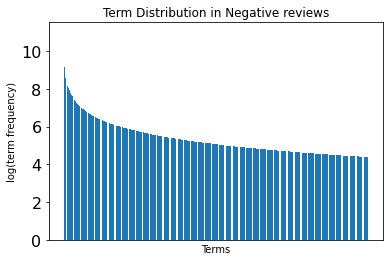

In [56]:
# Term Distribution - Negative - highest 10K terms

import math
dict_words = {k: math.log(v) for k, v in dict_words.items()}
dict_words = sorted(dict_words.items(), key=operator.itemgetter(1),reverse=True)
dict_words = dict_words[:10000]

plt.bar(*zip(*dict_words))
plt.title('Term Distribution in Negative reviews')
plt.xlabel('Terms')
plt.ylabel('log(term frequency)')
plt.xticks([], [])
plt.yticks(fontsize=16)
plt.show()

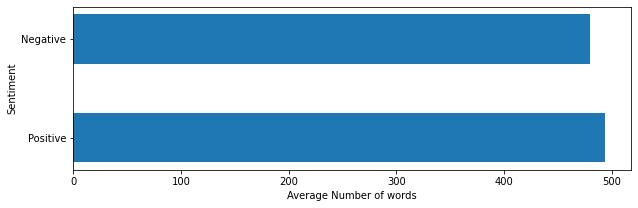

In [57]:
# Get mean of positive and negative reviews
avg_pos_reviews = csv_file[csv_file.sentiment=='positive'].review_text.apply(lambda x: len(x.split())).mean()
avg_neg_reviews = csv_file[csv_file.sentiment=='negative'].review_text.apply(lambda x: len(x.split())).mean()

plt.figure(figsize=(10, 3))
plt.barh(['Positive', 'Negative'], [avg_pos_reviews, avg_neg_reviews], height=0.5)
# plt.xticks(np.arange(0, 300, 25))
plt.xlabel('Average Number of words')
plt.ylabel('Sentiment')
plt.show()

Explain expected challenges:
1. as we can see from both graphs, the unigrams and bigrams are quite similar because the reviewers tend to mention words related to the movies and the story more often
2. each reviewer has his own opinion about the movie and uses different vocabulary to describe his thoughts and feelings which makes it difficult for us to find common and similar descripsions.
3. we can see that in the negative reviews that both 'bad' and 'good' are very common, which is very confusing to understand and decide whether the review is positive or negative
4. positive reviews has the same length as negative reviews in average numnber of words.


# Q2:

In [58]:
split=int(0.5*csv_file.shape[0])
train_data = csv_file[0:split]
valid_data = csv_file[split:]
train_data

,review,sentiment,review_text
0,"[one, reviewer, mentioned, watching, oz, episo...",positive,one reviewer mentioned watching oz episode hoo...
1,"[wonderful, little, production, filming, techn...",positive,wonderful little production filming technique ...
2,"[thought, wonderful, way, spend, time, hot, su...",positive,thought wonderful way spend time hot summer we...
3,"[basically, family, little, boy, jake, think, ...",negative,basically family little boy jake think zombie ...
4,"[petter, mattei, love, time, money, visually, ...",positive,petter mattei love time money visually stunnin...
...,...,...,...
24995,"[movie, real, torture, fest, sit, first, mista...",negative,movie real torture fest sit first mistake trea...
24996,"[john, wayne, albert, dekker, compete, oil, ri...",negative,john wayne albert dekker compete oil right ind...
24997,"[tarantino, remarked, melodrama, called, backs...",positive,tarantino remarked melodrama called backstreet...
24998,"[aah, yes, workout, show, great, many, woman, ...",positive,aah yes workout show great many woman get shap...


In [59]:
tagged_list = []

review_text_sentences = list(csv_file['review_text'])
print(review_text_sentences[0])
stokens = [nltk.word_tokenize(sentence) for sentence in review_text_sentences]

for stoken in stokens:        
     tagged_list.append(nltk.pos_tag(stoken))

# tagged_list

one reviewer mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show would dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience wa

In [60]:
from nltk.corpus import sentiwordnet as swn

lemmatizer_obj = nltk.WordNetLemmatizer()
score_list=[]

for idx,taggedsent in enumerate(tagged_list):  #iterate over all tokens
    score_list.append([])
    for idx2,t in enumerate(taggedsent):  #t[0] word, t[1] pos tag
        newtag=''
        lemmatized=lemmatizer_obj.lemmatize(t[0])
        if t[1].startswith('NN'):
            newtag='n'
        elif t[1].startswith('JJ'):
            newtag='a'
        elif t[1].startswith('V'):
            newtag='v'
        elif t[1].startswith('R'):
            newtag='r'
        else:
            newtag=''       
        if newtag!='' :    
            synsets = list(swn.senti_synsets(lemmatized, newtag))
            # print(lemmatized) # great
            # print(synsets) # [SentiSynset('great.s.01'), SentiSynset('great.s.02'), SentiSynset('great.s.03'), SentiSynset('bang-up.s.01'), SentiSynset('capital.s.03'), SentiSynset('big.s.13')]
            #synsets contains for each token the probability for negative, positive and objective
            #Getting average of all possible sentiments, as you requested        
            score=0
            if len(synsets)>0 :
                for syn in synsets:
                    # print("positive score ",syn.pos_score(),"negative score ",syn.neg_score(),"objective score ",syn.obj_score())
                    score+=syn.pos_score()-syn.neg_score()
                score_list[idx].append(score/len(synsets))


In [61]:
len(score_list)

50000

In [62]:
sentence_sentiment=[]

for score_sent in score_list:
  sum_sentence_score = sum(score_sent)   
  if len(score_sent) > 0:
    sentence_sentiment.append(sum_sentence_score/len(score_sent))
  else:
    sentence_sentiment.append(0)

print(len(sentence_sentiment))

50000


In [63]:
csv_file['review_score'] = sentence_sentiment


In [64]:
accuracy_pos = csv_file[csv_file['sentiment'] == 'positive'][csv_file['review_score'] > 0 ]
total_acc_pos = len(accuracy_pos)/pos_count

accuracy_neg = csv_file[csv_file['sentiment'] == 'negative'][csv_file['review_score'] < 0 ]
total_acc_neg = len(accuracy_neg)/neg_count

print(total_acc_pos)
print(total_acc_neg)
print((len(accuracy_pos)+len(accuracy_neg))/(pos_count+neg_count))



sentiment    0.86024
dtype: float64
sentiment    0.49832
dtype: float64
sentiment    0.67928
dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
